In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from lempel_ziv_complexity import lempel_ziv_complexity as lz

import lzma
import gzip
from lempel_ziv_welch import lempel_ziv_welch


In [4]:
def get_midis(folder):
    midis = []
    for f in os.listdir(folder):
        with open(f"{folder}/{f}", "rb") as handle:
            midi = handle.read()
            midis.append(midi)
    return os.listdir(folder), midis

def filename_from_index(folder, i):
    if type(i) is int:
        return os.listdir(folder)[i]
    else:
        return [os.listdir(folder)[j] for j in i]



def get_prefix(s, l):
    return s[:l]
get_prefix = np.vectorize(get_prefix)


# def normalised_complexity(s, compressor):
#     return len(compressor.compress(s))/(len(s))
# normalised_complexity = np.vectorize(normalised_complexity)


def complexity(compressor, normalise=True):
    norm = lambda x: len(x) if normalise else 1
    return np.vectorize(lambda s: len(compressor.compress(s))/norm(s))

In [5]:
def get_df(folder_name, norm=True, prefix=None):

    filenames, midis = get_midis(folder_name)

    if prefix:
        midis = get_prefix(midis, prefix)

    lengths = list(map(len, midis))

    complexities = [complexity(lzma, norm)(midis), complexity(gzip, norm)(midis), 
                    complexity(lempel_ziv_welch, norm)(midis)]

    complexities.append([lz(s)/(len(s) if norm else 1) for s in midis])


    args = [filenames, midis, lengths, *complexities]

    df = pd.DataFrame(list(zip(*args)),
                      columns=["filename", "string", "length", "K_lzma", "K_gzip", "K_lzw", "K_lz"])
    
    f = lambda *ls: np.multiply.reduce(ls)
    f = lambda *ls: np.minimum.reduce(ls)
    
    df["K_all"] = f(df.K_lzma, df.K_gzip, df.K_lzw, df.K_lz)
    
    
    return df


ai = get_df("computer_music", True)
human = get_df("human_music", True)

# Conditional Complexity

Let `K'(A) = size(gzip(A))`.

Define `K'(A|B) = K'(AB) - K(B)` analogous to the same definition for `K` and with `AB` the concatenation of `A` and `B`.

`K(A) + K(B) >= K(AB)` with equality if `A` and `B` contain no information about each other. This implies `K(A) >= K(AB) - K(B) = K(A|B)`

## Q: what could one condition on?

# 1. Look at Distributions

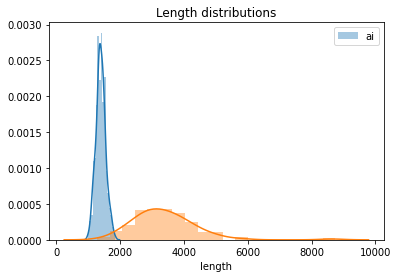

In [6]:
sns.distplot(ai.length, label="ai")
sns.distplot(human.length)
plt.legend(); plt.title("Length distributions"); plt.show()

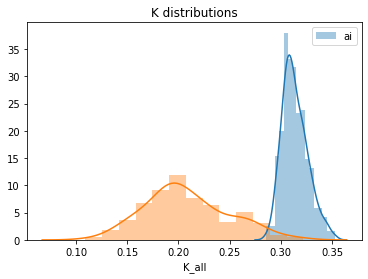

In [7]:
sns.distplot(ai.K_all, label="ai")
sns.distplot(human.K_all)
plt.legend(); plt.title("K distributions"); plt.show()

# 2. Get and Convert Samples

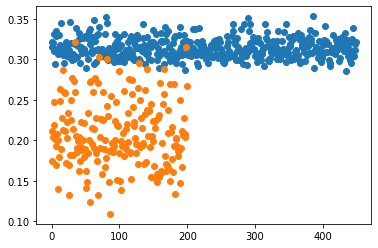

In [8]:
plt.scatter(range(len(ai)), ai.K_all)
plt.scatter(range(len(human)), human.K_all)

In [9]:
print("AI most aesthetic:",
      ai.iloc[np.argsort(ai.K_all)[:3]])


AI most aesthetic:              filename                                             string  \
434  combined_197.mid  b'MThd\x00\x00\x00\x06\x00\x01\x00\x02\x00\x18...   
196   combined_48.mid  b'MThd\x00\x00\x00\x06\x00\x01\x00\x02\x00\x18...   
387   combined_35.mid  b'MThd\x00\x00\x00\x06\x00\x01\x00\x02\x00\x18...   

     length    K_lzma    K_gzip     K_lzw      K_lz     K_all  
434    1750  0.285714  0.404571  0.561714  0.290286  0.285714  
196    1718  0.316647  0.381257  0.559371  0.286962  0.286962  
387    1718  0.316647  0.405122  0.574505  0.288708  0.288708  


In [10]:
np.asarranp.argsort([2,5,1])

AttributeError: module 'numpy' has no attribute 'asarranp'

In [11]:
np.argsort(ai.K_all)[:3]

0    434
1    196
2    387
Name: K_all, dtype: int64

In [ ]:
ai.iloc[0:3]

In [ ]:
for i in range(3):
    ! cp -v computer_music/

In [ ]:

l = 
k = 3
first_inds = list(range(k))
last_inds = list(range())

for i in range(-3, 0, 1):
    f = filename_from_index("computer_music", i)
    print(i, f)
    ! cp -v computer_music/$f ugly_music/
    newname = f"computer_{i}.midi"
    ! mv ugly_music/$f ugly_music/$newname

In [ ]:
for f in os.listdir("ugly_music"):
    mp3name = f.replace(".midi", ".mp3")
    ! timidity ugly_music/$f -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k ugly_music/$mp3name

## Read MIDI files into binary strings


In [ ]:
ai_midis = get_midis("computer_music") 

human_midis = get_midis("human_music")

ai_midis = get_prefix(ai_midis, 1000)
human_midis = get_prefix(human_midis, 1000)

ai_midis = np.random.choice(ai_midis, size=len(human_midis), replace=False)

In [ ]:
ai_lengths = list(map(len, ai_midis))
human_lengths = list(map(len, human_midis))
sns.distplot(ai_lengths, label="AI")
sns.distplot(human_lengths)
plt.legend()

In [ ]:
ai_complexities = normalised_complexity(ai_midis, lzma)
human_complexities = normalised_complexity(human_midis, lzma)

In [ ]:
sns.distplot(ai_complexities)
sns.distplot(human_complexities)

In [ ]:
ai_aesthetic_sort = np.argsort(ai_complexities)#[::-1]
human_aesthetic_sort = np.argsort(human_complexities)[::-1]

print(ai_aesthetic_sort[:3], ai_aesthetic_sort[-3:])

In [ ]:
plt.scatter(range(len(ai_complexities)), ai_complexities)

In [ ]:
[i for i in range(len(os.listdir("computer_music"))) if os.listdir("computer_music")[i] == "combined_386.mid"]

# Crop the mp3 files to 15 seconds 

 - use ffmpeg: `ffmpeg -t 30 -acodec copy -i inputfile.mp3 outputfile.mp3`

# Apply Lempel-Ziv Complexity Measurement 

 - unsing the package `lempel-ziv-complexity` which references https://en.wikipedia.org/wiki/Lempel-Ziv_complexity
 - the lz-complexity values are heavily correlated with length (was to be expected), so use normalised complexity 
 - instead of `len()` should actually use `sys.getsizeof()` for the object's byte-size (length in bytes), but the two are strongly correlated, so results are highly similar

In [ ]:
lz_complexities = list(map(lz, midis))
normed_lz_complexities = [c/l for c, l in zip(complexities, lengths)]
sns.distplot(normed_lz_complexities, label="len")
plt.legend()

# Apply LZMA

In [ ]:
import lzma

In [ ]:
lzma_complexities = [len(lzma.compress(m))/len(m) for m in midis]

In [ ]:
sns.distplot(lzma_complexities)

In [ ]:
sns.jointplot(normed_lz_complexities, lzma_complexities)

In [ ]:
f = np.argmin
f(normed_lz_complexities), f(lzma_complexities),\
f([c1*c2 for c1, c2 in zip(normed_lz_complexities, lzma_complexities)])

In [ ]:
sns.scatterplot(lzma_complexities, [c1*c2 for c1, c2 in zip(normed_lz_complexities, lzma_complexities)])

In [ ]:
os.listdir("combined")[266]

In [ ]:
np.argsort([abs(c-np.median(lzma_complexities)) for c in lzma_complexities])[:10]

# Eurovision Song Contest Data (Human Music)

In [ ]:
human_midis = []
for f in os.listdir("human_music/"):
    with open(f"human_music/{f}", "rb") as handle:
        midi = handle.read()
        human_midis.append(midi)

In [ ]:
len(human_midis), len(midis)

In [ ]:
human_lengths = list(map(len, human_midis))
sns.distplot(lengths, label="AI")
sns.distplot(human_lengths)
plt.legend()

In [ ]:
human_lzma_complexities = [len(lzma.compress(m))/len(m) for m in human_midis]
sns.distplot(human_lzma_complexities)
sns.distplot(lzma_complexities, label="AI")
plt.legend()

In [ ]:
sns.jointplot(lzma_complexities, human_lzma_complexities)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

strs = [m.decode("latin-1") for m in midis]
human_strs = [m.decode("latin-1") for m in human_midis]

vocab = set.union(*map(set, strs)) | set.union(*map(set, human_strs))

vectorizer = CountVectorizer(vocabulary=vocab)

vecs = vectorizer.fit_transform(strs) 
human_vecs = vectorizer.fit_transform(human_strs) 

In [ ]:
len(vocab)

In [ ]:
vecs.toarray().shape

In [ ]:
with open("embeddings.tsv", "w") as handle:
    for v in vecs.toarray():
        print(v.shape)
        handle.write("\t".join(map(str, v)))
        handle.write("\n")
    for v in human_vecs.toarray():
        print(v.shape)
        handle.write("\t".join(map(str, v)))
        handle.write("\n")
        
        
with open("meta.tsv", "w") as handle:
    handle.write("is_human\tcomplexity\n")
    for v, c in zip(vecs, lzma_complexities):
        handle.write("\t".join(("0", str(round(c, 3)))))
        handle.write("\n")
    for v, c in zip(human_vecs, human_lzma_complexities):
        handle.write("\t".join(("1", str(round(c, 3)))))
        handle.write("\n")     

In [ ]:
midis[0].decode("latin-1")

---
# TODO EXPERIMENTS

 - assess distribution of human (eurovision data) MIDIs, compare to vNine
 
 - embed all MIDIs, both human and vNine, in vector space (how?), annotate with (1) `is_human` and (2) `C_lzma`, use projector.tensorflow.org to visualise (and supervised t-SNE to see separation)
 
 - 


# Observations

- computer music is more complex than human music (compression_size/size is on average twice as high); human music varies more in complexity <br>
  => human music would be perceived as more aesthetic <br>
  => AI music could be more complex (= more random) because of randomness used in production
  
  
- 


# THINGS TO TALK ABOUT

## Formalising Aesthetics: HOWTO

 - disclaimer: it is doubtable whether human aesthetics can be fully captured by mathematics at all; so, at least for the moment, no approach can fully cover the nature of what humans find aesthetically valuable; on a related note, aesthetic likely has strong subjective aspects, so there likely isn't a unified/objective theory that works for every human

 - aesthetics from a philosophical/mathematical perspective -> e.g. Wittgenstein: _aesthetic judgements_ are expressions of how much "the rules" have been adhered to and distinct from _appreciation_
 
 
 - cognitive science/(psychology ?)/(anthropology ?): the mind (being predctive) has a preference for "simple rules" -> therefore, aesthetic judgements correlate with how simple objects are since simplicity is an inherent principle in the "rules"
 
 
 - more explanation on simplicity preference: the mind tries to avoid and reduce uncertainty, i.e. it strives to position itself in its environment s.t. it can easily predict what will happen next; according to theory (and also intuitively), simple things are easy to predict because they are more likely, so the mind prefers being in contexts where simple things are abundant
 
 
 - simplicity preference need not be absolute but may be conditioned on expressiveness ("given that I want to express X, what is the simplest way of doing so"); simplicity may be in the details or in the very basics, hence "hidden" from the viewer
 
 
 - examples of simplicity in society include highly regular shapes in everyday objects, [MORE]
 
 
 - examples of simplicity in art include symmetry in painting, recurring motives in music, simples harmonies in music, reduced colour schemes in painting, abstract art
 
 
 - simpicity (or rather its inverse, complexity) is an important and well-studied concept in computer science, in the guise of Kolmogorov complexity; according to this theory, simplicity in its truest form is not computable, so we cannot judge what would have been the absolute simplest alternative; but we can approximate simplicity, so [MORE]
 
 - funnily and conveniently, simplicity can be measured very easily by off-the-shelf compression programs, so measuring the simplicity of a song is as simple as compressing its MIDI (or any other) representation (and dividing by the byte-size of the MIDI file, giving the compression rate, which makes values more comparable)
 
 - summa summarum: by 
 
 
## But Why?

 - a computer scientist's (cognitive scientist's) lense on aesthetics; if we can supply the AI, why should we not also get to join discussions on aesthetics; as should have become clear, I also have theories and an academic tradition (even if young) to draw from and join the discussion
 
 
 - the mirror aspect
 
 - the agency aspect (not to be taken too seriously): if a computer can create music, it can also judge its aesthetic value; in a way,  